# Import

In [1]:
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed
from prophet import Prophet
set_random_seed(0)
%matplotlib inline
warnings.filterwarnings('ignore')

# Preprocessing

## data load

In [2]:
# 중찬씨가 전처리하신 data, 2021년 4월 1일~, 각 시점별 팁교체 여부로 0, 1 표기
l1 = pd.read_csv('../../PREPROCESSING/very_clean_data/one_left.csv',
                 index_col=0, parse_dates=['시각'], infer_datetime_format=True)
r1 = pd.read_csv('../../PREPROCESSING/very_clean_data/one_right.csv',
                 index_col=0, parse_dates=['시각'], infer_datetime_format=True)
l2 = pd.read_csv('../../PREPROCESSING/very_clean_data/two_left.csv',
                 index_col=0, parse_dates=['시각'], infer_datetime_format=True)
r2 = pd.read_csv('../../PREPROCESSING/very_clean_data/two_right.csv',
                 index_col=0, parse_dates=['시각'], infer_datetime_format=True)

# rename columns
l1.columns = ['v', 'a', 'g', 't', 'EA', '시각', '팁교체']
r1.columns = ['v', 'a', 'g', 't', 'EA', '시각', '팁교체']
l2.columns = ['v', 'a', 'g', 't', 'EA', '시각', '팁교체']
r2.columns = ['v', 'a', 'g', 't', 'EA', '시각', '팁교체']

## prepare for prophet 

In [3]:
# prophet은 한번에 하나의 feature만 받고, feature를 y, 시각을 ds로 지정해주어야 하기 때문에 형태 변경 definition을 만들어주었음
def make_seperate(df, y, ds):
    temp = df.copy()
    original_columns = temp.columns
    temp['y'] = temp[y]
    temp['ds'] = temp[ds]

    return temp.drop(original_columns, axis=1)

## prepare for rolling test

In [4]:
def rolling_for(df, n):  # df를 index n단위로 split, temp3 for train, temp5 for test 시간만 채워져 있는 dataset
    temp = []
    temp2 = pd.DataFrame()
    temp3 = []
    temp5 = []

    for i in range((len(l1)//n) + 1):
        temp.append(df[i*n:(i+1)*n].reset_index(drop=True))
        temp2 = pd.concat([temp2, temp[i]]).reset_index(drop=True)
        temp3.append(temp2)
        temp4 = temp3[i].copy()
        temp4['y'][i*n:(i+1)*n] = None
        temp5.append(temp4)

    return temp3, temp5

# Modeling

## neural_prophet

In [5]:
# definite
def neural_prophet(df):
    model = NeuralProphet(
        
        # trend, seasonality
        
        growth="linear",  # trend의 type linear, discontinuous, off
        ##changepoints=None # list of dates that may include change points (None -> automatic)
        ##n_changepoints=100,
        changepoints_range=0.9, 
        ##trend_reg=2,
        ##trend_reg_threshold=False,
        ##yearly_seasonality='auto',
        weekly_seasonality='auto',
        daily_seasonality='auto',
        seasonality_mode="multiplicative", # multiplicative는 계절성이 추세에 따라 곱으로, additive는 합으로
        seasonality_reg=1,
        
        # auto regression
        
        ##n_lags=60, # n_lags 개를 가지고 n_forecasts 개를 자기회귀로 예측, arnet 활성, predict 할 때 예측할 빈 y의 개수를 맞춰줘야함 현재는 임의로 잘라주었기에 활성화하지 않음
        ##n_forecasts=30,
        ##num_hidden_layers=2, # ar_net layer 설정
        ##ar_sparsity=0.01, # ar_net regularize, 내 버전에 호환되지 않는듯
        ##d_hidden=None,
        ##ar_reg=None,
        
        # etc parameter
        
        learning_rate=None,
        epochs=100,
        batch_size=128,
        loss_func='Huber', # mse, rmse 등 torch의 loss_func 사용가능 huber가 anormaly에 robust하다고 함
        optimizer='AdamW',
        ##newer_samples_weights=2,
        ##newer_samples_start=0.0,
        ##impute_missing=True, # null 채우기
        ##collect_metrics=True,
        normalize='auto', # Type of normalization minmax, standardize, soft, off, auto
        ##global_normalization=False,
        ##global_time_normalization=True,,
        ##unknown_data_normalization=False
    )
    metrics = model.fit(df, freq='D', progress='bar')

    return model

In [6]:
def one_touch(machine, direction, unit, searching_split):

    columns = ['a', 'v', 'g', 't']

    if (machine == 1) & (direction == 'left'):
        for i in columns:
            globals()['check_' + i] = neural_prophet(rolling_for(
                make_seperate(l1, i, '시각'), unit)[0][searching_split-1])
            globals()['forecast_' + i] = globals()['check_' + i].predict(
                rolling_for(make_seperate(l1, i, '시각'), unit)[1][searching_split])
            globals()['check_' + i].plot(globals()['forecast_' + i])

        return forecast_a, forecast_v, forecast_g, forecast_t

    if (machine == 1) & (direction == 'right'):
        for i in columns:
            globals()['check_' + i] = neural_prophet(rolling_for(
                make_seperate(r1, i, '시각'), unit)[0][searching_split-1])
            globals()['forecast_' + i] = globals()['check_' + i].predict(
                rolling_for(make_seperate(r1, i, '시각'), unit)[1][searching_split])
            globals()['check_' + i].plot(globals()['forecast_' + i])

        return forecast_a, forecast_v, forecast_g, forecast_t

    if (machine == 2) & (direction == 'left'):
        for i in columns:
            globals()['check_' + i] = neural_prophet(rolling_for(
                make_seperate(l2, i, '시각'), unit)[0][searching_split-1])
            globals()['forecast_' + i] = globals()['check_' + i].predict(
                rolling_for(make_seperate(l2, i, '시각'), unit)[1][searching_split])
            globals()['check_' + i].plot(globals()['forecast_' + i])

        return forecast_a, forecast_v, forecast_g, forecast_t

    if (machine == 2) & (direction == 'right'):
        for i in columns:
            globals()['check_' + i] = neural_prophet(rolling_for(
                make_seperate(r2, i, '시각'), unit)[0][searching_split-1])
            globals()['forecast_' + i] = globals()['check_' + i].predict(
                rolling_for(make_seperate(r2, i, '시각'), unit)[1][searching_split])
            globals()['check_' + i].plot(globals()['forecast_' + i])

        return forecast_a, forecast_v, forecast_g, forecast_t

INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency 15S corresponds to 57.864% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.


  0%|          | 0/188 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.62E-01, min: 3.03E-07


  0%|          | 0/188 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.45E-01, min: 8.84E-04
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.33E-01
Epoch[100/100]: 100%|█| 100/100 [02:31<00:00,  1.52s/it, SmoothL1Loss=0.00841, M
INFO - (NP.df_utils._infer_frequency) - Major frequency 15S corresponds to 57.878% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 15S corresponds to 57.878% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonali

  0%|          | 0/188 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.83E-02, min: 5.47E-01


  0%|          | 0/188 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.83E-02, min: 4.38E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.27E-02
Epoch[100/100]: 100%|█| 100/100 [02:31<00:00,  1.51s/it, SmoothL1Loss=0.00442, M
INFO - (NP.df_utils._infer_frequency) - Major frequency 15S corresponds to 57.878% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 15S corresponds to 57.878% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonali

  0%|          | 0/188 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.29E-02, min: 1.13E-02


  0%|          | 0/188 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.29E-02, min: 1.26E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.52E-02
Epoch[100/100]: 100%|█| 100/100 [02:34<00:00,  1.55s/it, SmoothL1Loss=0.00926, M
INFO - (NP.df_utils._infer_frequency) - Major frequency 15S corresponds to 57.878% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 15S corresponds to 57.878% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonali

  0%|          | 0/188 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.28E-02, min: 1.85E+00


  0%|          | 0/188 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.83E-02, min: 1.85E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.47E-02
Epoch[100/100]: 100%|█| 100/100 [02:32<00:00,  1.53s/it, SmoothL1Loss=0.000773, 
INFO - (NP.df_utils._infer_frequency) - Major frequency 15S corresponds to 57.878% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 15S corresponds to 57.878% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.


(                        ds      y      yhat1  residual1      trend  \
 0      2021-04-01 08:30:51  20.47  19.858364  -0.611636  20.007000   
 1      2021-04-01 08:33:47  20.43  19.864241  -0.565759  20.007124   
 2      2021-04-01 08:34:02  20.32  19.864754  -0.455246  20.007135   
 3      2021-04-01 08:34:17  20.31  19.865269  -0.444731  20.007145   
 4      2021-04-01 08:34:33  20.36  19.865822  -0.494178  20.007156   
 ...                    ...    ...        ...        ...        ...   
 340418 2022-03-29 17:36:59    NaN  20.353344        NaN  20.559240   
 340419 2022-03-29 17:59:52    NaN  20.309608        NaN  20.559250   
 340420 2022-03-29 18:07:47    NaN  20.293501        NaN  20.559254   
 340421 2022-03-29 18:12:40    NaN  20.283592        NaN  20.559258   
 340422 2022-03-29 18:14:15    NaN  20.280403        NaN  20.559258   
 
         season_weekly  season_daily  
 0            0.004999     -0.035045  
 1            0.005012     -0.033894  
 2            0.005013     -0

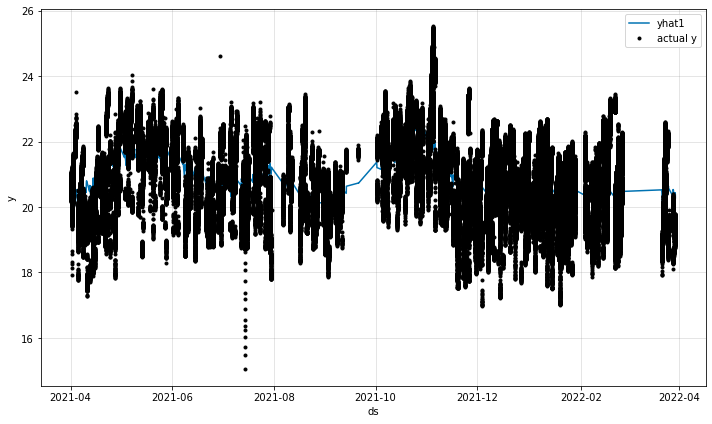

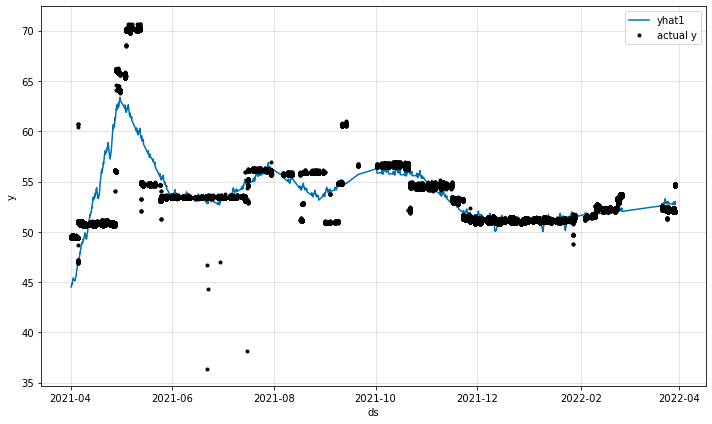

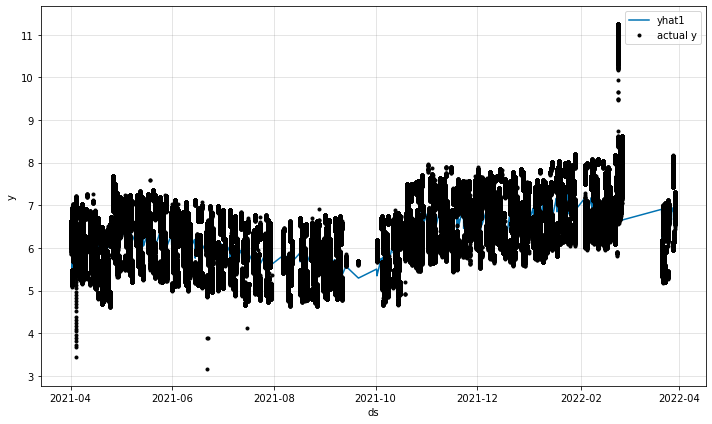

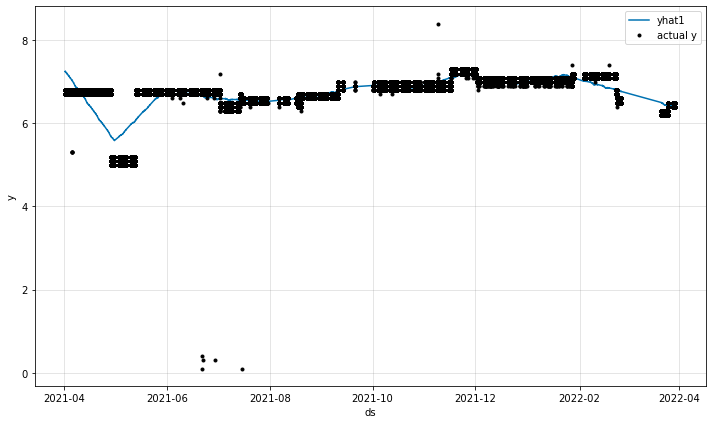

In [7]:
# example
# 1호기 왼쪽 dataframe을 index 2000개 단위로 split, split data 중 169번째까지 train, 170번째 test
one_touch(1, 'left', 2000, 170)

# EMA

In [8]:
# 지수이동평균으로 상한 하한 잡기 기준 3시그마
def ema(mean_number):  # n = 이동평균으로 묶을 데이터의 수

    df = pd.DataFrame()
    df['A_predict'] = forecast_a['yhat1']
    df['V_predict'] = forecast_v['yhat1']
    df['G_predict'] = forecast_g['yhat1']
    df['T_predict'] = forecast_t['yhat1']

    ewm = df.ewm(span=mean_number).mean()
    std = df.ewm(span=mean_number).std()
    upper = ewm + 3*std
    lower = ewm - 3*std
    columns = df.columns
    upper.columns = columns + '_upper'
    lower.columns = columns + '_lower'
    temp = pd.concat([df, upper], axis=1)
    temp = pd.concat([temp, lower], axis=1)

    return temp

In [9]:
# 상, 하한을 보고싶은 feature('A', 'V', 'G', 'T'), ema할 때 평균을 낼 data의 개수, plot에 표시할 index
def pllott(feature, mean_number, index):
    plt.figure(figsize=(25, 15))
    plt.plot(ema(mean_number)[feature + '_predict'][:index], 'red', ema(mean_number)[feature +
             '_predict_upper'][:index], 'green', ema(mean_number)[feature + '_predict_lower'][:index], 'green')

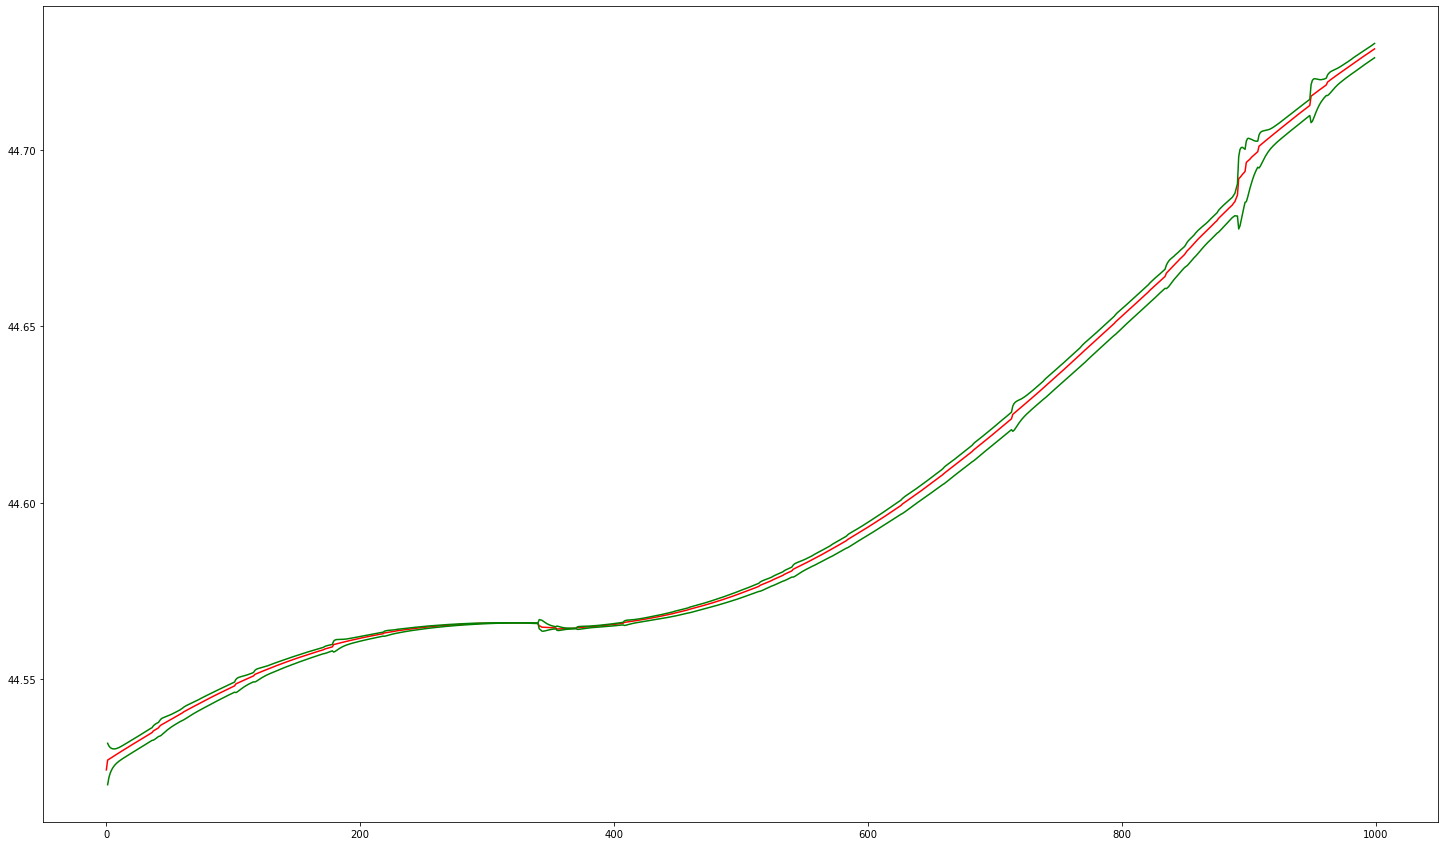

In [10]:
pllott('V', 5, 1000)

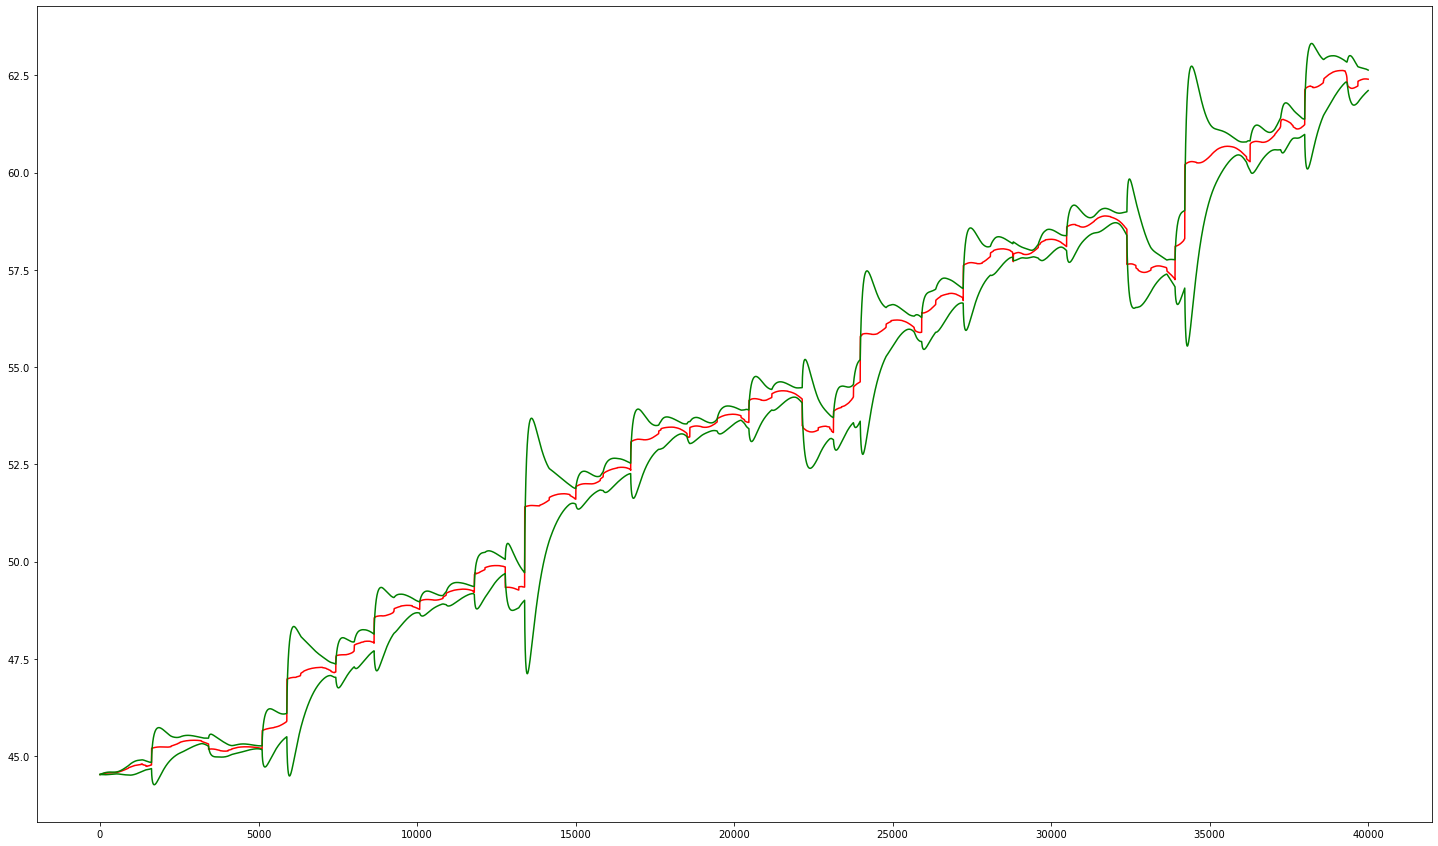

In [11]:
pllott('V', 400, 40000)